In [1]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform, shift
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
import imageio
from matplotlib.widgets import Slider

In [2]:
def translate_to_origin(points):
    """
    Translates a set of points so that their centroid is at the origin.
    
    Parameters:
    points (numpy.ndarray): An array of shape (3, 3) representing the vertices of the triangle.
    
    Returns:
    numpy.ndarray: Translated points with the centroid at the origin.
    numpy.ndarray: The original centroid of the points.
    """
    centroid = np.mean(points, axis=0)
    translated_points = points - centroid
    return translated_points, centroid

def scale_to_match(points1, points2):
    """
    Scales points1 to match the scale of points2.
    
    Parameters:
    points1 (numpy.ndarray): An array of shape (3, 3) representing the vertices of the first triangle.
    points2 (numpy.ndarray): An array of shape (3, 3) representing the vertices of the second triangle.
    
    Returns:
    numpy.ndarray: Scaled points1.
    float: The scaling factor.
    """
    size1 = np.linalg.norm(points1[1] - points1[0])
    size2 = np.linalg.norm(points2[1] - points2[0])
    scale_factor = size2 / size1
    scaled_points1 = points1 * scale_factor
    return scaled_points1, scale_factor

def kabsch_algorithm(P, Q):
    """
    Finds the optimal rotation matrix using the Kabsch algorithm.
    
    Parameters:
    P (numpy.ndarray): An array of shape (3, 3) representing the vertices of the first triangle.
    Q (numpy.ndarray): An array of shape (3, 3) representing the vertices of the second triangle.
    
    Returns:
    numpy.ndarray: The rotation matrix.
    """
    C = np.dot(P.T, Q)
    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        V[:, -1] = -V[:, -1]

    rotation_matrix = np.dot(V, W)
    return rotation_matrix

def align_triangles(triangle1, triangle2):
    """
    Aligns triangle1 to triangle2.
    
    Parameters:
    triangle1 (numpy.ndarray): An array of shape (3, 3) representing the vertices of the first triangle.
    triangle2 (numpy.ndarray): An array of shape (3, 3) representing the vertices of the second triangle.
    
    Returns:
    numpy.ndarray: Transformed vertices of triangle1.
    numpy.ndarray: The rotation matrix.
    numpy.ndarray: The translation vector.
    float: The scaling factor.
    """
    # Step 1: Translate both triangles to origin
    translated_triangle1, centroid1 = translate_to_origin(triangle1)
    translated_triangle2, centroid2 = translate_to_origin(triangle2)
    print(centroid1,centroid2)
    print(np.mean(translated_triangle1, axis=0), np.mean(translated_triangle2, axis=0) )
    
    # Step 2: Scale triangle1 to match the size of triangle2
    scaled_triangle1, scale_factor = scale_to_match(translated_triangle1, translated_triangle2)
    
    # Step 3: Find the optimal rotation using the Kabsch algorithm
    rotation_matrix = kabsch_algorithm(scaled_triangle1, translated_triangle2)
    
    # Apply the rotation to scaled_triangle1
    rotated_triangle1 = np.dot(scaled_triangle1, rotation_matrix)
    
    # Translate rotated_triangle1 back to the position of triangle2
    transformed_triangle1 = rotated_triangle1 + centroid2
    
    return transformed_triangle1, rotation_matrix, centroid2 - scale_factor * np.dot(centroid1, rotation_matrix), scale_factor, centroid1, centroid2

def align_stacks(centroid1, centroid2, stack1, stack2, scale_factor, rotation_matrix):

    #need to add padding to stack1 so that features do not roll off the volume cube
    large_canvas = np.zeros((stack2.shape+abs(np.round(centroid2).astype(int))))
    starting_idx = np.round(centroid2).astype(int)
    # large_canvas[z,y,x] = stack1
    
    translated_stack1 = apply_translation_to_image_stack(stack1,-centroid1)
    translated_stack1 = crop_window(translated_stack1, -centroid1)

    # visualize_image_stack_all_at_once(teanslated_stack1)

    # Step 2: Scale stack1 to match the size of stack2
    new_shape = tuple(np.round(np.array(translated_stack1.shape)*scale_factor).astype(int))
    scaled_stack1 = resize(stack1, new_shape, mode='constant', anti_aliasing=True)

    # Step 3: Apply the rotation to scaled_stack1
    rotated_stack1 = apply_rotation_matrix(scaled_stack1, rotation_matrix)
    
    # step3.5 maybe?
    #add padding to stack_1 this time to match dimensions of stack2

    # step 4: Translate rotated_stack1 back to the position of stack2
    transformed_stack1 = apply_translation_to_image_stack(rotated_stack1,centroid2)

    # stack_diff = 
    
    return transformed_stack1

def crop_window(stack, translation):
    pass
def rotation_matrix_to_euler_angles(R):
    """
    Extracts the Euler angles from a rotation matrix.
    
    Parameters:
    R (numpy.ndarray): A 3x3 rotation matrix.
    
    Returns:
    tuple: The Euler angles (theta_x, theta_y, theta_z) in radians.
    """
    assert R.shape == (3, 3), "Input rotation matrix must be 3x3"
    
    if R[2, 0] != 1 and R[2, 0] != -1:
        theta_y = -np.arcsin(R[2, 0])
        cos_theta_y = np.cos(theta_y)
        theta_x = np.arctan2(R[2, 1] / cos_theta_y, R[2, 2] / cos_theta_y)
        theta_z = np.arctan2(R[1, 0] / cos_theta_y, R[0, 0] / cos_theta_y)
    else:
        # Gimbal lock case
        theta_z = 0
        if R[2, 0] == -1:
            theta_y = np.pi / 2
            theta_x = np.arctan2(R[0, 1], R[0, 2])
        else:
            theta_y = -np.pi / 2
            theta_x = np.arctan2(-R[0, 1], -R[0, 2])
    
    return theta_x, theta_y, theta_z

def rotation_matrix_from_angles(theta_x, theta_y, theta_z):
    """
    Creates a combined rotation matrix from rotations around the x, y, and z axes.
    
    Parameters:
    theta_x (float): Rotation angle around the x-axis in degees.
    theta_y (float): Rotation angle around the y-axis in degrees.
    theta_z (float): Rotation angle around the z-axis in degrees.
    
    Returns:
    numpy.ndarray: The combined rotation matrix.
    """
    theta_x = np.radians(theta_x)
    theta_y = np.radians(theta_y)
    theta_z = np.radians(theta_z)
    # Rotation matrix for the x-axis
    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(theta_x), -np.sin(theta_x)],
        [0, np.sin(theta_x), np.cos(theta_x)]
    ])
    
    # Rotation matrix for the y-axis
    R_y = np.array([
        [np.cos(theta_y), 0, np.sin(theta_y)],
        [0, 1, 0],
        [-np.sin(theta_y), 0, np.cos(theta_y)]
    ])
    
    # Rotation matrix for the z-axis
    R_z = np.array([
        [np.cos(theta_z), -np.sin(theta_z), 0],
        [np.sin(theta_z), np.cos(theta_z), 0],
        [0, 0, 1]
    ])
    
    # Combined rotation matrix
    R = np.dot(R_z, np.dot(R_y, R_x))
    
    return R

def apply_rotation_matrix(image_stack, rotation_matrix):
    """
    Applies a rotation matrix to a 3D image stack.
    
    Parameters:
    image_stack (numpy.ndarray): A 3D numpy array representing the image stack (depth, height, width).
    rotation_matrix (numpy.ndarray): A 3x3 rotation matrix.
    
    Returns:
    numpy.ndarray: The rotated image stack, same shape as the input.
    """
    # Compute the center of the image stack
    center = np.array(image_stack.shape) / 2
    
    # Construct the affine transformation matrix
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    transformation_matrix[:3, 3] = center - np.dot(rotation_matrix, center)
    
    # Apply the affine transformation
    rotated_image_stack = affine_transform(
        image_stack, 
        transformation_matrix[:3, :3], 
        offset=transformation_matrix[:3, 3],
        mode='nearest'
    )
    
    return rotated_image_stack

def visualize_image_stacks(original_stack, rotated_stack):
    """
    Visualizes the original and rotated image stacks.
    
    Parameters:
    original_stack (numpy.ndarray): The original 3D image stack.
    rotated_stack (numpy.ndarray): The rotated 3D image stack.
    """
    fig, axes = plt.subplots(2, original_stack.shape[0], figsize=(15, 5))
    
    for i in range(original_stack.shape[0]):
        axes[0, i].imshow(original_stack[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original Slice {i+1}')
        
        axes[1, i].imshow(rotated_stack[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Rotated Slice {i+1}')
    
    plt.tight_layout()
    plt.show()

def visualize_image_stack(image_stack):
    """
    Visualizes individual images from a 3D image stack.
    
    Parameters:
    image_stack (numpy.ndarray): A 3D array representing the image stack.
    """
    # Initial slice index
    slice_index = 0

    # Create a figure and axis to plot the images
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25, bottom=0.25)
    image_display = ax.imshow(image_stack[slice_index], cmap='gray')
    ax.set_title(f'Slice {slice_index}')

    # Create the slider axis and slider
    ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])
    slider = Slider(ax_slider, 'Slice', 0, image_stack.shape[0] - 1, valinit=slice_index, valfmt='%0.0f')

    def update(val):
        slice_index = int(slider.val)
        image_display.set_data(image_stack[slice_index])
        ax.set_title(f'Slice {slice_index}')
        fig.canvas.draw_idle()

    slider.on_changed(update)

    plt.show()

def plot_triangles(triangle1, transformed_triangle1, triangle2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Original triangle1
    ax.scatter(triangle1[:, 0], triangle1[:, 1], triangle1[:, 2], color='r', label='Original Triangle 1')
    ax.plot(triangle1[:, 0], triangle1[:, 1], triangle1[:, 2], color='r')
    
    # Transformed triangle1
    ax.scatter(transformed_triangle1[:, 0], transformed_triangle1[:, 1], transformed_triangle1[:, 2], color='b', label='Transformed Triangle 1')
    ax.plot(transformed_triangle1[:, 0], transformed_triangle1[:, 1], transformed_triangle1[:, 2], color='b')
    
    # Triangle 2
    ax.scatter(triangle2[:, 0], triangle2[:, 1], triangle2[:, 2], color='g', label='Triangle 2')
    ax.plot(triangle2[:, 0], triangle2[:, 1], triangle2[:, 2], color='g')
    
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

def animate_plot_triangles(triangle1, transformed_triangle1, triangle2, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Setting up the plot elements that will be updated
    orig_scatter, = ax.plot(triangle1[:, 0], triangle1[:, 1], triangle1[:, 2], 'ro-', label='Original Triangle 1')
    trans_scatter, = ax.plot(transformed_triangle1[:, 0], transformed_triangle1[:, 1], transformed_triangle1[:, 2], 'bo-', label='Transformed Triangle 1')
    target_scatter, = ax.plot(triangle2[:, 0], triangle2[:, 1], triangle2[:, 2], 'go-', label='Triangle 2')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    
    # Animation function
    def update(num):
        ratio = num / 100
        trans_points = (1 - ratio) * triangle1 + ratio * transformed_triangle1
        
        trans_scatter.set_data(trans_points[:, 0], trans_points[:, 1])
        trans_scatter.set_3d_properties(trans_points[:, 2])
        
        # Rotate the plot view
        ax.view_init(elev=30, azim=num * 3.6)
        
        return trans_scatter,
    
    ani = FuncAnimation(fig, update, frames=101, interval=10, blit=False)
    
    # Save animation as GIF
    ani.save(filename, writer=PillowWriter(fps=20))
    plt.show()


def apply_transform_to_image_stack(image_stack, rotation_matrix, translation_vector, scale_factor):
    """
    Applies the given rotation matrix, translation vector, and scale factor to a 3D image stack.
    
    Parameters:
    image_stack (numpy.ndarray): A 3D array representing the image stack.
    rotation_matrix (numpy.ndarray): A 3x3 rotation matrix.
    translation_vector (numpy.ndarray): A translation vector of length 3.
    scale_factor (float): The scaling factor for image dimensions.
    
    Returns:
    numpy.ndarray: The transformed 3D image stack.
    """
    # Compute the new shape of the image stack after scaling
    new_shape = tuple(int(dim * scale_factor) for dim in image_stack.shape)
    
    # Create an affine transformation matrix for scaling
    scale_matrix = np.eye(4)
    np.fill_diagonal(scale_matrix, [scale_factor, scale_factor, scale_factor, 1])
    
    # Create an affine transformation matrix for rotation and translation
    affine_matrix = np.eye(4)
    affine_matrix[:3, :3] = rotation_matrix
    affine_matrix[:3, 3] = translation_vector

    # Combine scaling and affine transformation
    combined_matrix = np.dot(affine_matrix, scale_matrix)

    # Apply the combined affine transformation
    transformed_image_stack = affine_transform(
        image_stack, 
        combined_matrix[:3, :3], 
        offset=combined_matrix[:3, 3],
        output_shape=new_shape,
        order=1,
        mode='constant',
        cval=0.0
    )

    return transformed_image_stack
def apply_translation_to_image_stack(image_stack, translation_vector):
    """
    Applies the given translation vector to a 3D image stack.
    
    Parameters:
    image_stack (numpy.ndarray): A 3D array representing the image stack.
    translation_vector (numpy.ndarray): A translation vector of length 3.
    
    Returns:
    numpy.ndarray: The translated 3D image stack.
    """
    # Create an identity matrix for the rotation part
    identity_matrix = np.eye(3)
    
    # Apply the affine transformation with the identity matrix and translation vector
    translated_image_stack = affine_transform(
        image_stack, 
        matrix=identity_matrix, 
        offset=translation_vector,
        order=1,
        mode='constant',
        cval=0.0
    )

    return translated_image_stack

def visualize_image_stack_side_by_side(image_stack, n_slices=5):
    """
    Visualizes individual images from a 3D image stack side by side.
    
    Parameters:
    image_stack (numpy.ndarray): A 3D array representing the image stack.
    n_slices (int): Number of slices to display side by side.
    """
    # Initial slice index
    slice_index = 0

    # Create a figure and axes to plot the images
    fig, axes = plt.subplots(1, n_slices, figsize=(15, 5))
    plt.subplots_adjust(left=0.1, bottom=0.25, right=0.9, top=0.9, wspace=0.5)

    # Initialize the displayed images
    image_displays = []
    for i in range(n_slices):
        ax = axes[i]
        if i < image_stack.shape[0]:
            img = ax.imshow(image_stack[slice_index + i], cmap='gray')
            ax.set_title(f'Slice {slice_index + i}')
        else:
            img = ax.imshow(np.zeros_like(image_stack[0]), cmap='gray')
            ax.set_title('Empty Slice')
        image_displays.append(img)

    # Create the slider axis and slider
    ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])
    slider = Slider(ax_slider, 'Slice', 0, image_stack.shape[0] - n_slices, valinit=slice_index, valfmt='%0.0f')

    def update(val):
        slice_index = int(slider.val)
        for i in range(n_slices):
            if slice_index + i < image_stack.shape[0]:
                image_displays[i].set_data(image_stack[slice_index + i])
                axes[i].set_title(f'Slice {slice_index + i}')
            else:
                image_displays[i].set_data(np.zeros_like(image_stack[0]))
                axes[i].set_title('Empty Slice')
        fig.canvas.draw_idle()

    slider.on_changed(update)

    plt.show()

def visualize_image_stack_all_at_once(image_stack, max_cols=5):
    """
    Visualizes all individual images from a 3D image stack at once in a subplot with a maximum column size of 5.
    
    Parameters:
    image_stack (numpy.ndarray): A 3D array representing the image stack.
    max_cols (int): Maximum number of columns in the subplot grid.
    """
    num_slices = image_stack.shape[0]
    num_cols = min(max_cols, num_slices)
    num_rows = int(np.ceil(num_slices / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
    axes = axes.flatten()

    for i in range(num_slices):
        ax = axes[i]
        ax.imshow(image_stack[i], cmap='gray')
        ax.set_title(f'Slice {i}')
        ax.axis('off')

    # Turn off any unused axes
    for i in range(num_slices, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def insert_array_in_center(larger_array, smaller_array):
    """
    Inserts a smaller 3D array into the center of a larger 3D array of zeros.
    
    Parameters:
    larger_array (numpy.ndarray): The larger 3D array of zeros.
    smaller_array (numpy.ndarray): The smaller 3D array to be inserted.
    
    Returns:
    numpy.ndarray: The larger array with the smaller array inserted in the center.
    """
    # Calculate the starting indices to insert the smaller array
    start_indices = np.array([(l - s) // 2 for l, s in zip(larger_array.shape, smaller_array.shape)])
    
    # Calculate the ending indices
    end_indices = start_indices + smaller_array.shape
    
    # Insert the smaller array into the larger array
    larger_array[start_indices[0]:end_indices[0], 
                 start_indices[1]:end_indices[1], 
                 start_indices[2]:end_indices[2]] = smaller_array
    
    return larger_array

def create_slice_from_string(expr):
    """
    Converts a string expression to a slice object.
    
    Parameters:
    expr (str): The string expression representing the slice.
    
    Returns:
    slice: The slice object created from the string expression.
    """
    # Split the expression into parts
    parts = expr.split(':')
    
    # Convert parts to start, stop, and step
    start = int(parts[0]) if parts[0] else None
    stop = int(parts[1]) if len(parts) > 1 and parts[1] else None
    step = int(parts[2]) if len(parts) > 2 and parts[2] else None

    return slice(start, stop, step)

def slice_3d_array(expr_x, expr_y, expr_z):
    """
    Slices a 3D array using string expressions for each axis.
    
    Parameters:
    array (numpy.ndarray): The input 3D array.
    expr_x (str): The string expression representing the slice for the x-axis.
    expr_y (str): The string expression representing the slice for the y-axis.
    expr_z (str): The string expression representing the slice for the z-axis.
    
    Returns:
    numpy.ndarray: The sliced array.
    """
    slice_x = create_slice_from_string(expr_x)
    slice_y = create_slice_from_string(expr_y)
    slice_z = create_slice_from_string(expr_z)
    
    return slice_x, slice_y, slice_z


In [4]:

lami2ide = tiff.imread("lami2ide.tiff")
lami2bm = tiff.imread("lami2bm.tiff")

ptsA = np.array([[24.        , 75.95091768, 65.79039979],
       [24.        , 70.9054519 , 46.52589411],
       [22.        , 46.3661411 , 46.98457282]])
ptsB = np.array([[ 64.        , 247.03623188, 602.80434783],
       [ 64.        ,  64.47101449, 502.15942029],
       [ 47.        , 137.02898551, 256.39855072]])

transformed_triangle1, R, T, scale_factor, centroid1, centroid2 = align_triangles(ptsB, ptsA)
# transformed_stack = align_triangles_and_stacks(lami2bm, lami2ide, ptsB, ptsA)
theta_x, theta_y, theta_z = rotation_matrix_to_euler_angles(R)
print("Theta_x (degrees):", np.degrees(theta_x))
print("Theta_y (degrees):", np.degrees(theta_y))
print("Theta_z (degrees):", np.degrees(theta_z))




[ 58.33333333 149.51207729 453.78743961] [23.33333333 64.40750356 53.10028891]
[-2.36847579e-15 -2.36847579e-14  0.00000000e+00] [1.18423789e-15 7.10542736e-15 2.36847579e-15]
Theta_x (degrees): 74.87819475287897
Theta_y (degrees): -7.566873849234817
Theta_z (degrees): -175.7378789293015


array([4, 5, 6])

In [26]:
#need to add padding to stack1 so that features do not roll off the volume cube
z = np.round(lami2bm.shape[0]//2-centroid1[0]).astype(int)
y = np.round(lami2bm.shape[1]//2-centroid1[1]).astype(int)
x = np.round(lami2bm.shape[2]//2-centroid1[2]).astype(int)
#need to place centroid to center of volume prior to applying rotation matrix 
alt_centroid = np.array([z,y,x])
# print(lami2bm.shape)
# print(centroid1)
# print(z,y,x)

# large_canvas = np.zeros((lami2bm.shape+(np.abs(np.round(centroid1))).astype(int)))
# large_canvas[:lami2bm.shape[0],:lami2bm.shape[1],:lami2bm.shape[2]] = lami2bm
# translated_stack1 = apply_translation_to_image_stack(large_canvas,-centroid1)


if x>0:
    str_x = f":{lami2bm.shape[2]}"
else:
    str_x = f"-{abs(lami2bm.shape[2])}:"
if y>0:
    str_y = f":{lami2bm.shape[1]}"
else:
    str_y = f"-{abs(lami2bm.shape[1])}:"
if z>0:
    str_z = f":{lami2bm.shape[0]}"
else:
    str_z = f"-{abs(lami2bm.shape[0])}:"

large_canvas = np.zeros(lami2bm.shape+(np.abs(alt_centroid)))
large_canvas[:lami2bm.shape[0], :lami2bm.shape[1], -lami2bm.shape[2]:] = lami2bm.shape[2]
translated_stack1 = apply_translation_to_image_stack(large_canvas,alt_centroid)


# large_canvas[:38, :173, -38:]

slice(-646, None, None) slice(None, 646, None) slice(None, 193, None)
(231, 819, 777)
(193, 646, 646)


(193, 646, 646)


In [15]:

large_canvas[slice_z, slice_y, xlice_x].shape
lami2bm.shape
# translated_stack1 = apply_translation_to_image_stack(large_canvas,-alt_centroid)


(193, 646, 646)

In [ ]:
slice_3d_array


In [ ]:
visualize_image_stack_all_at_once(translated_stack1)


(252, 796, 1100)
(254, 796, 1100)


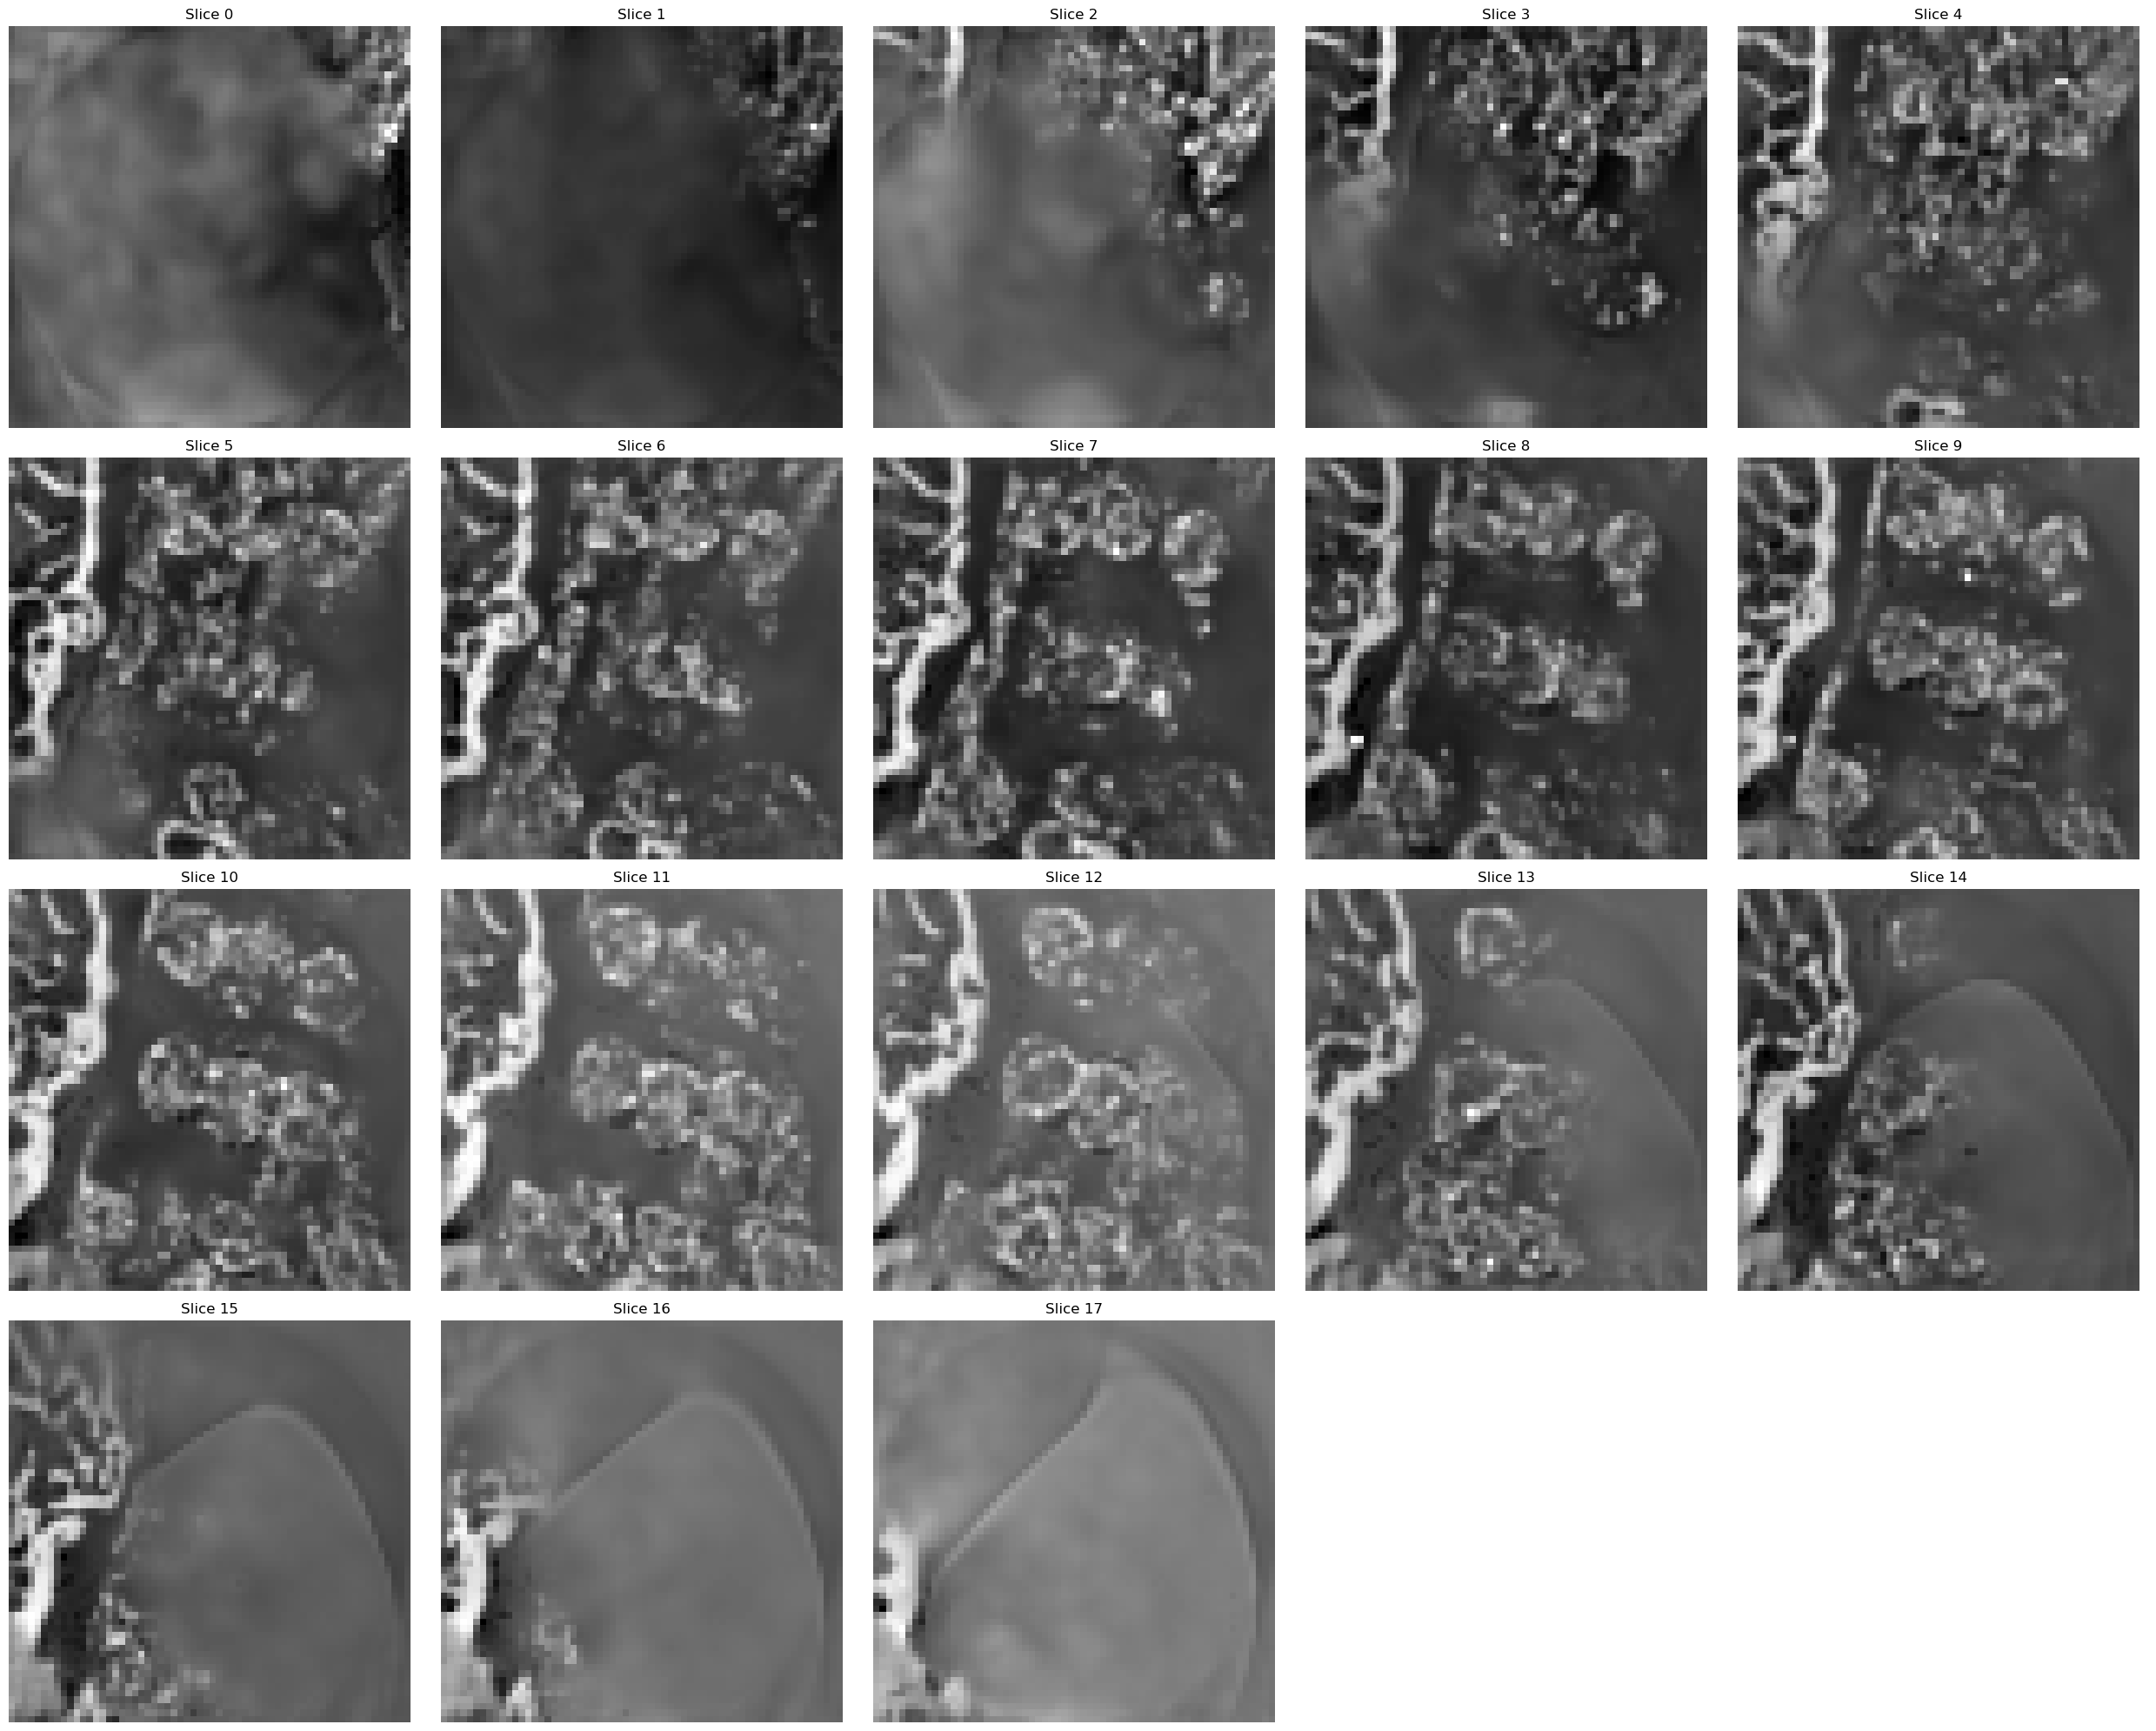

In [163]:
#need to add padding to stack1 so that features do not roll off the volume cube
large_canvas = np.zeros((lami2bm.shape+np.ceil(np.abs(centroid1)).astype(int)))
large_canvas[:lami2bm.shape[0],:lami2bm.shape[1],:lami2bm.shape[2]] = lami2bm
#need to place centroid to center of image prior to applying rotation matrix 
translated_stack1 = apply_translation_to_image_stack(large_canvas,-centroid1)
visualize_image_stack_all_at_once(translated_stack1)


# #cropping to new window
starting_idx = np.ceil((centroid1)).astype(int)
translated_stack1 = translated_stack1[starting_idx[0]:,starting_idx[1]:,starting_idx[2]:]

# Step 2: Scale stack1 to match the size of stack2
new_shape = tuple(np.round(np.array(translated_stack1.shape)*scale_factor).astype(int))
scaled_stack1 = resize(translated_stack1, new_shape, mode='constant', anti_aliasing=True)
# visualize_image_stack_all_at_once(scaled_stack1)

# Step 3: Apply the rotation to scaled_stack1
R = rotation_matrix_from_angles(100, -7.614750914315949, -175.4495067449307)
rotated_stack1 = apply_rotation_matrix(scaled_stack1, R)
# visualize_image_stack_all_at_once(translated_stack1)



In [115]:
x = np.array([0,1,2,3])
x[-2:]

array([2, 3])

In [157]:
#re-padd with zeros array of the size of stack2

large_canvas2 = np.zeros_like(lami2ide)
print(centroid2) #if shifts are negative, put colon to the right of -stack.shape[axis]:, if positive, put colon to the right of :stack.shape[axis]
# large_canvas2 = insert_array_in_center(np.zeros_like(lami2ide), rotated_stack1)
# large_canvas2[-rotated_stack1.shape[0]:, -rotated_stack1.shape[1]:, -rotated_stack1.shape[2]:] = rotated_stack1
large_canvas2[:rotated_stack1.shape[0], :rotated_stack1.shape[1], :rotated_stack1.shape[2]] = rotated_stack1
transformed_stack1 = apply_translation_to_image_stack(large_canvas2,-centroid2)
print(large_canvas2.shape)


[23.33333333 64.40750356 53.10028891]
(56, 120, 120)


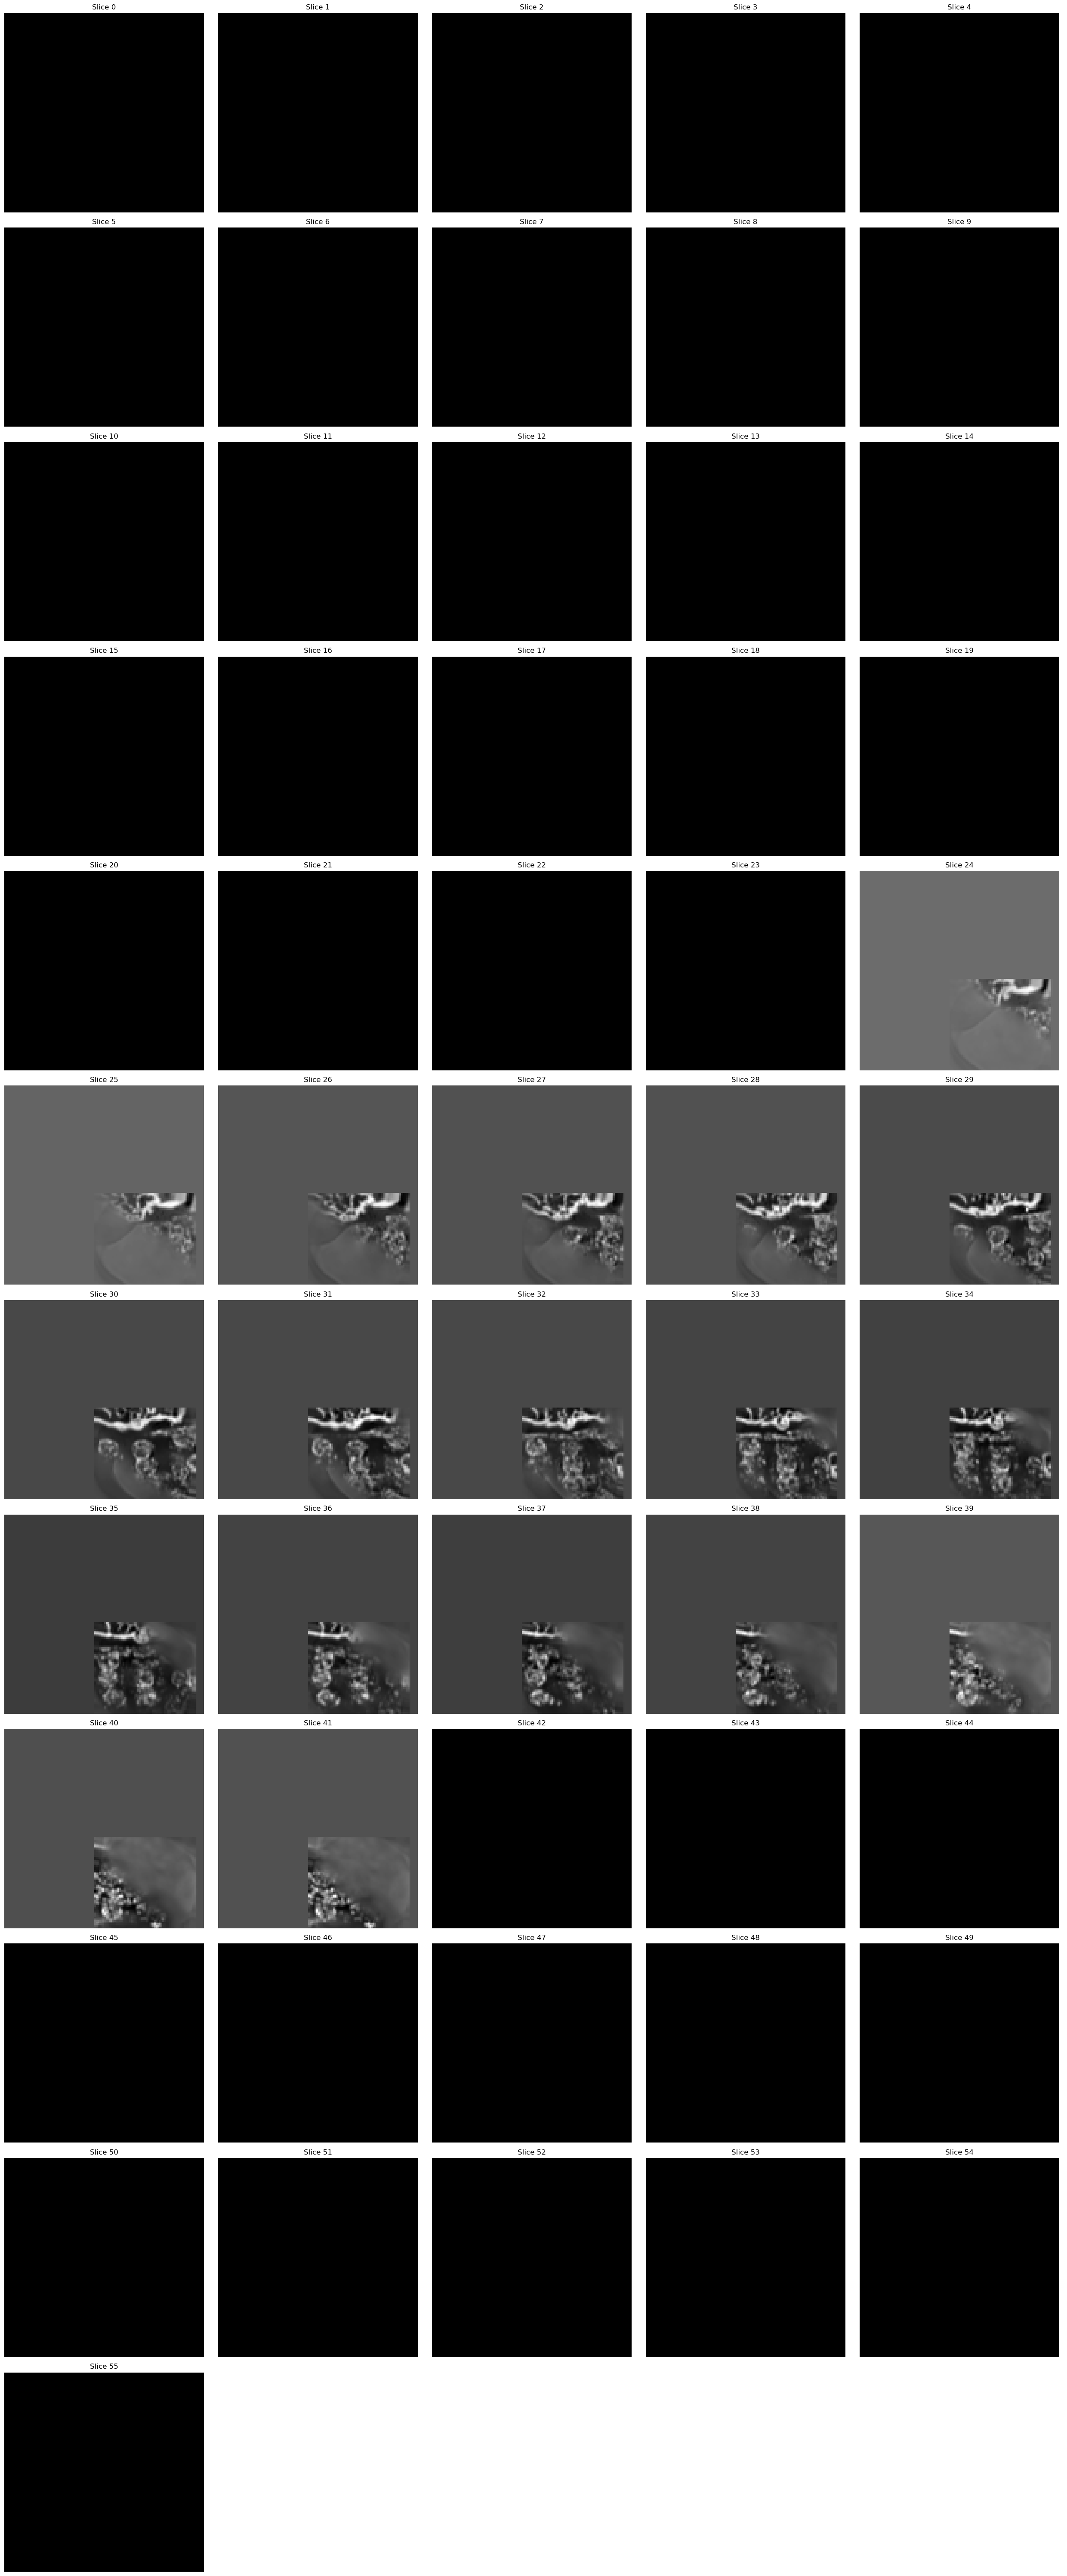

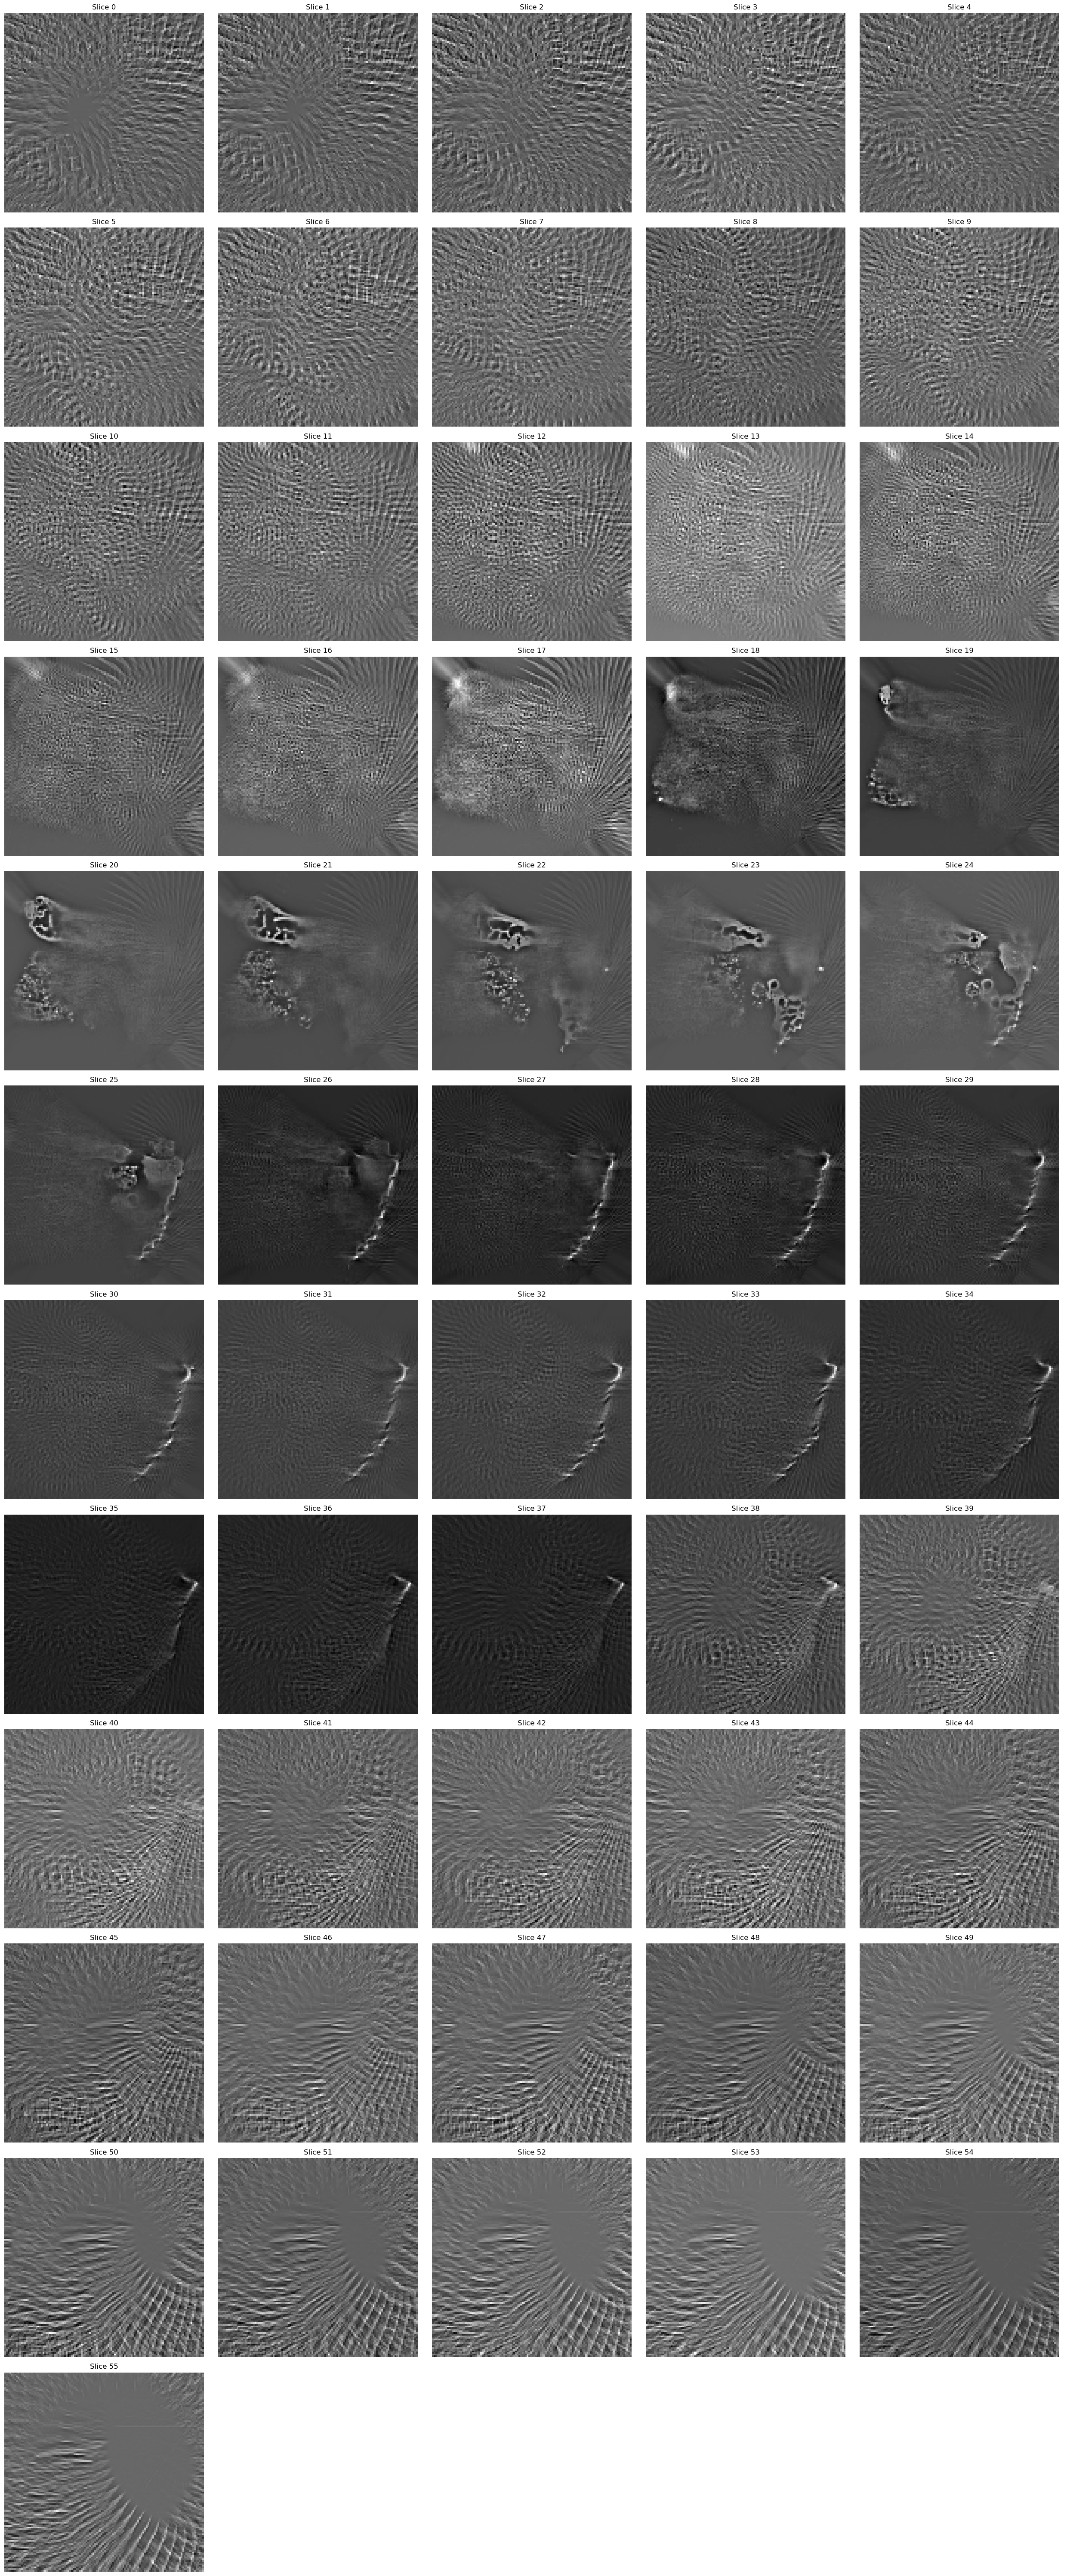

In [158]:
visualize_image_stack_all_at_once(transformed_stack1)
visualize_image_stack_all_at_once(lami2ide)


In [ ]:





# step3.5 maybe?
#add padding to stack_1 this time to match dimensions of stack2

# step 4: Translate rotated_stack1 back to the position of stack2
transformed_stack1 = apply_translation_to_image_stack(rotated_stack1,centroid2)

# stack_diff = 


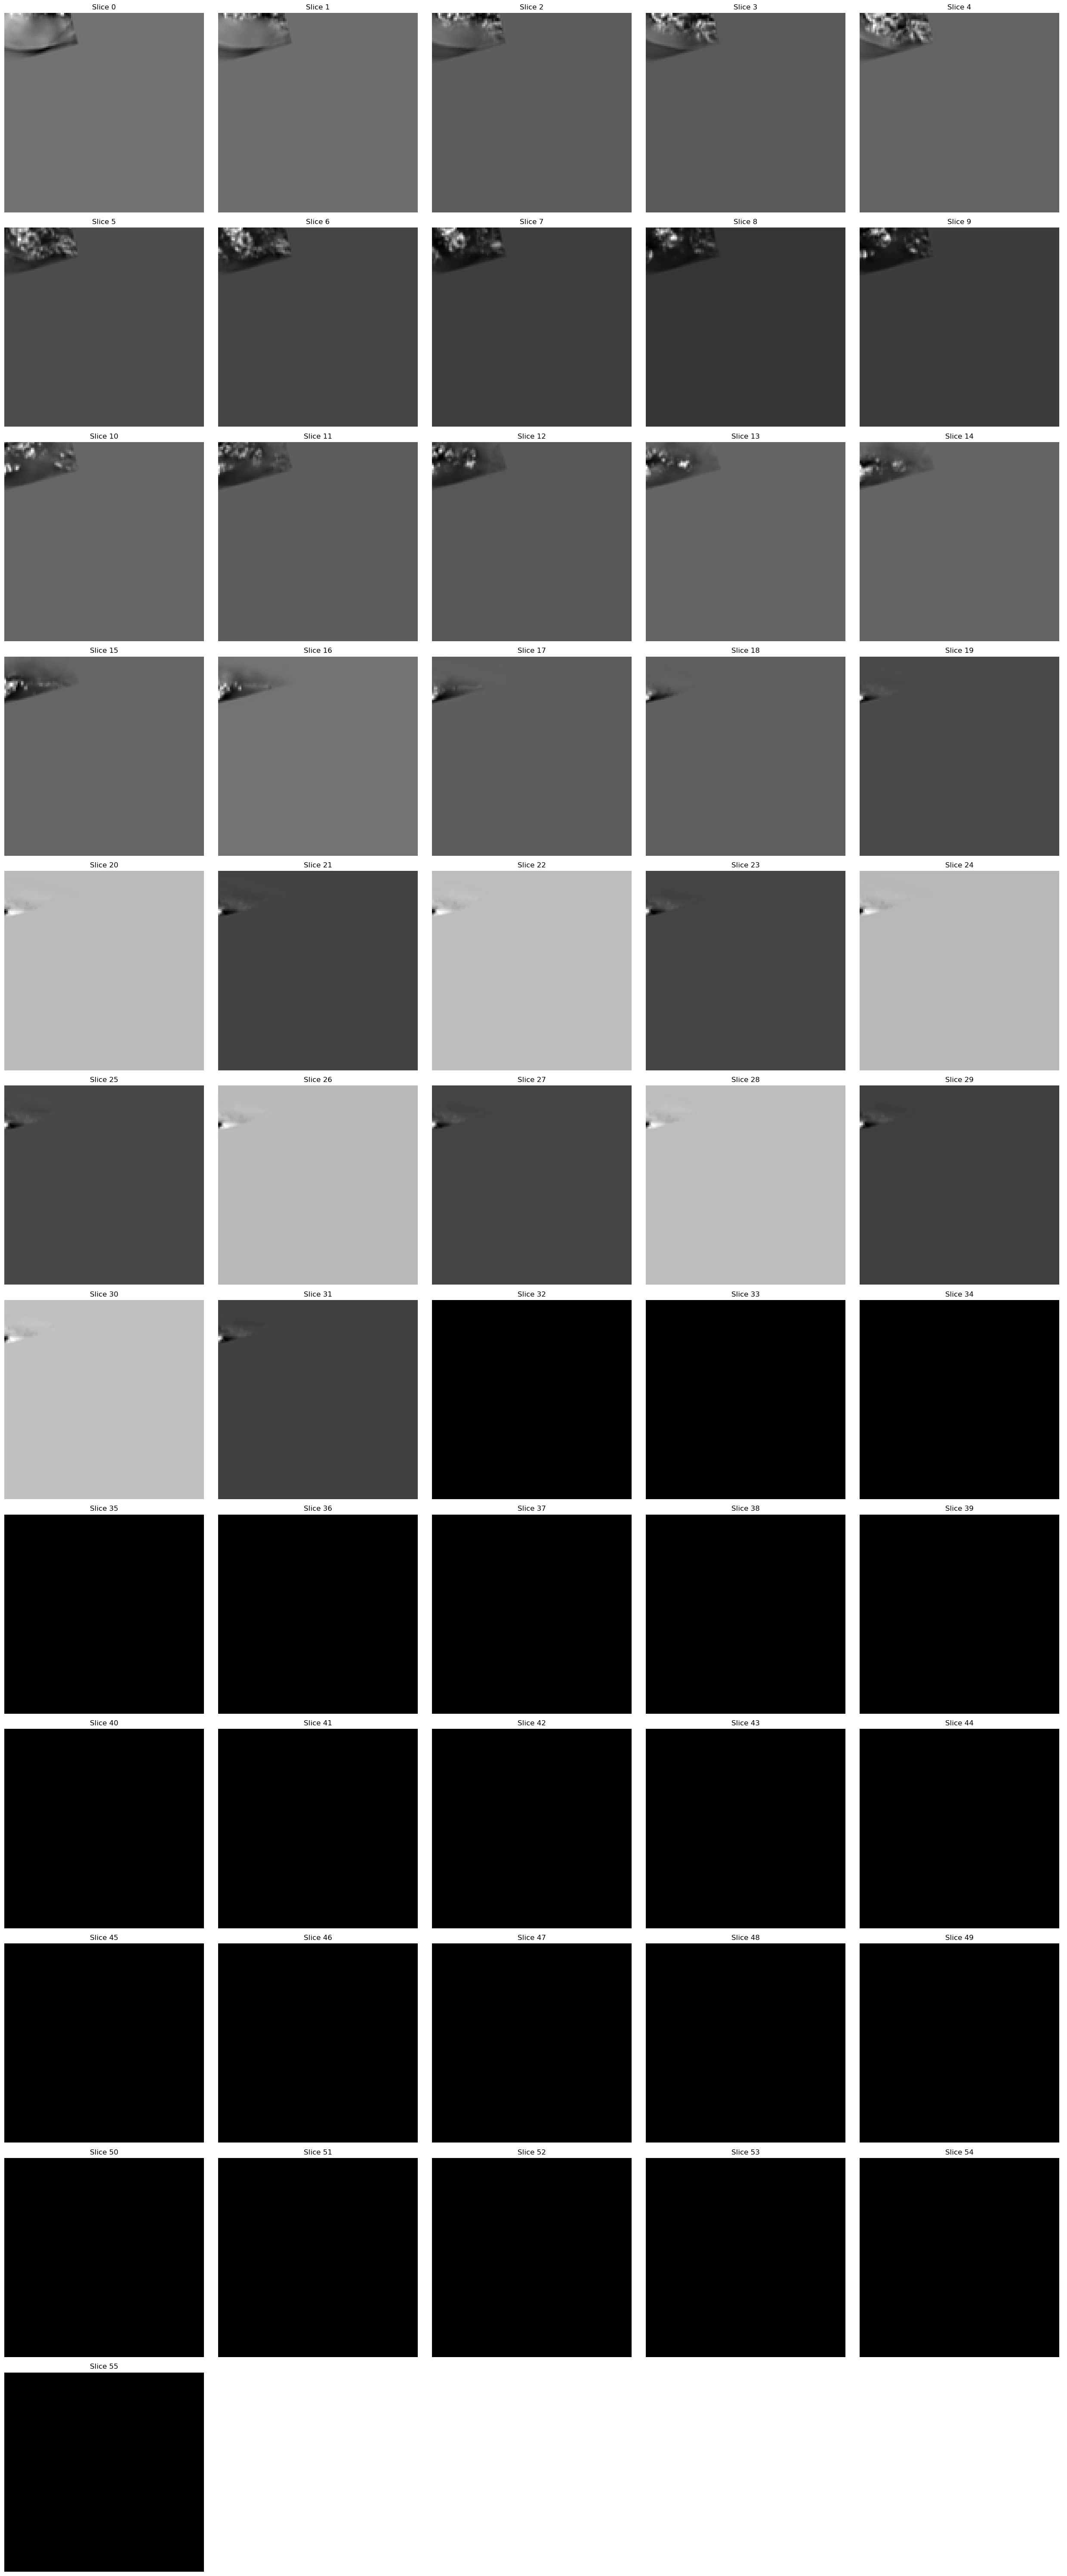

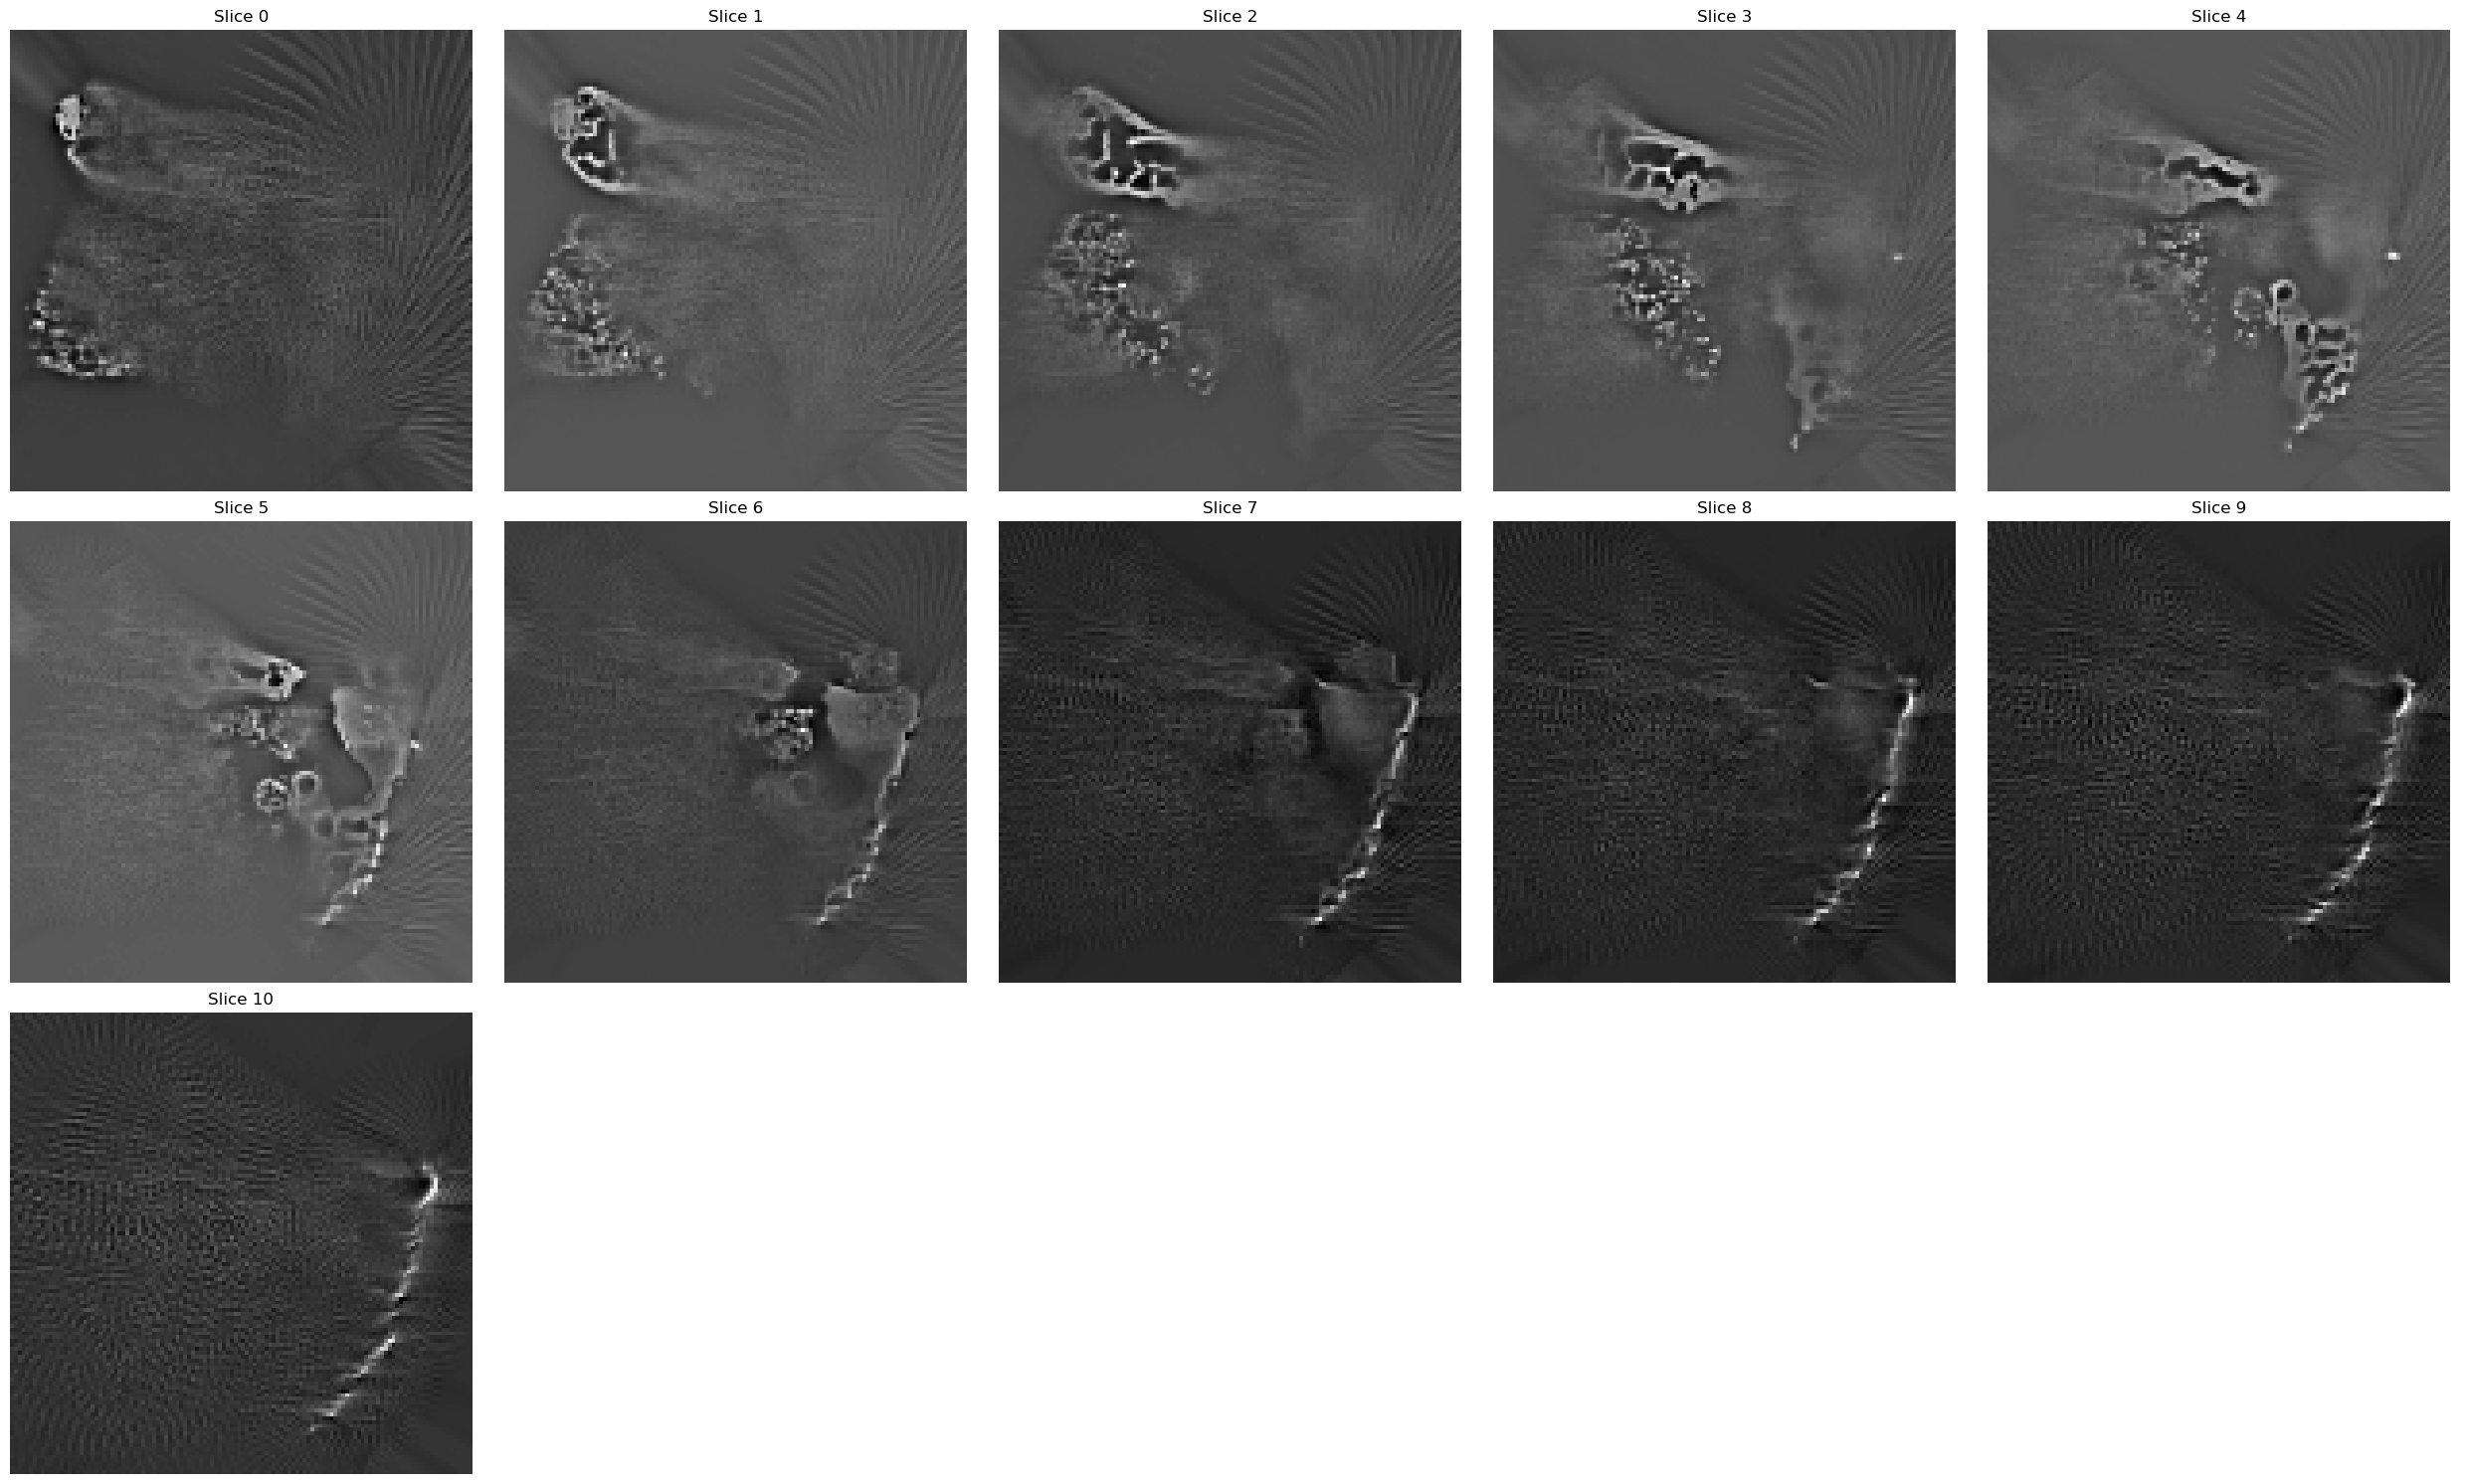

In [44]:
visualize_image_stack_all_at_once(transformed_stack)
visualize_image_stack_all_at_once(lami2ide[19:30])

In [34]:
R = rotation_matrix_from_angles(100, -7.614750914315949, -175.4495067449307)

(3, 3)


array([24.1858192 , 25.69054025, 28.31315174])

In [33]:
# rotated_stack = apply_rotation_matrix(downscaled, R)

# rotated_stack = apply_transform_to_image_stack(lami2bm, R, translation_vector, scale_factor)

#shift images to centroid
# translated_image_stack = shift(downscaled, shift=translation_vector, mode='nearest')
# visualize_image_stacks(lami2ide[20:26], rotated_stack[20:26])


imageio.mimwrite('rotated_stack.tif', rotated_stack.astype(np.float32), format='tiff')



In [ ]:
animate_plot_triangles(ptsB, transformed_triangle1, ptsA, 'triangle_alignment.gif' )